**Least Squares Fit Example using iminuit**


Fitting example using iminuit (https://iminuit.readthedocs.io).  iminuit is a Jupyter-friendly Python interface for the Minuit2 C++ library maintained by CERN’s ROOT team.

Minuit was designed to optimize statistical cost functions, for maximum-likelihood and least-squares fits. It provides the best-fit parameters and error estimates from likelihood profile analysis.

In [1]:
!pip install iminuit

import numpy as np
import matplotlib.pyplot as plt
import iminuit as iminuit
#import iminuit

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
print("iminuit version:", iminuit.__version__)

from pprint import pprint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.3/439.3 kB 9.0 MB/s eta 0:00:00
iminuit version: 2.30.1


**Define data**

In [2]:
xd = np.array([0.5, 1., 1.5, 2.,  2.5, 3.,  3.5, 4.,  4.5, 5.])
yd = np.array([1.1,1.2, 1.5, 1.8, 2.1, 2.3, 2.6, 3.1, 3.5, 4.0])
yd_err = np.array([0.5, 0.6, 0.2, 0.4, 0.3, 0.2, 0.4, 0.3,0.4, 0.5])


**Define fit function**

In [3]:
def f(x, theta0, theta1):
    return theta0 + theta1 * x

**Define χ2 function**

Minuit finds the minimum of a multi-variate function. We need to define a χ2 function which is then minimized by iminuit.

In [4]:
def chi2(theta0, theta1):
    fy = f(xd, theta0, theta1)
    diffs = (yd - fy) / yd_err
    return np.sum(diffs**2)

**Initialize minuit and perform the fit**

By default, Minuit assumes that the callable fcn behaves like chi-square function, meaning that the function minimum in repeated identical random experiments is chi-square distributed up to an arbitrary additive constant. This is important for the correct error calculation. If fcn returns a log-likelihood, one should multiply the result with -2 to adapt it. If the function returns the negated log-likelihood, one can alternatively set the attribute fcn.errordef = Minuit.LIKELIHOOD or Minuit.errordef = Minuit.LIKELIHOOD after initialization to make Minuit calculate errors properly.

In [5]:
m = Minuit(chi2, theta0 = 1, theta1 = 0.5)
m.errordef= Minuit.LEAST_SQUARES
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.301                      │              Nfcn = 28               │
│ EDM = 1.26e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ theta0 │   0.53    │   0.25    │            │            │         │         │       │
│ 1 │ theta1 │   0.63    │   0.09    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────┐
│        │ theta0 theta1 │
├────────┼───────────────┤
│ theta0 │ 0.0635 -0.020 │
│ theta1 │ -0.020 0.0075 │
└────────┴───────────────┘

In [6]:
for p in m.parameters:
    print(f"{p} = {m.values[p]:.6f}" \
          f" +/- {m.errors[p]:.6f}")

theta0 = 0.527649 +/- 0.251900
theta1 = 0.633080 +/- 0.086627


In [7]:
# covariance matrix
print(m.covariance)

┌────────┬───────────────┐
│        │ theta0 theta1 │
├────────┼───────────────┤
│ theta0 │ 0.0635 -0.020 │
│ theta1 │ -0.020 0.0075 │
└────────┴───────────────┘


**Plot results**

In [8]:
xf = np.linspace(0., 6., 1000)
theta0 = m.values["theta0"]
theta1 = m.values["theta1"]
yf = f(xf, theta0, theta1)

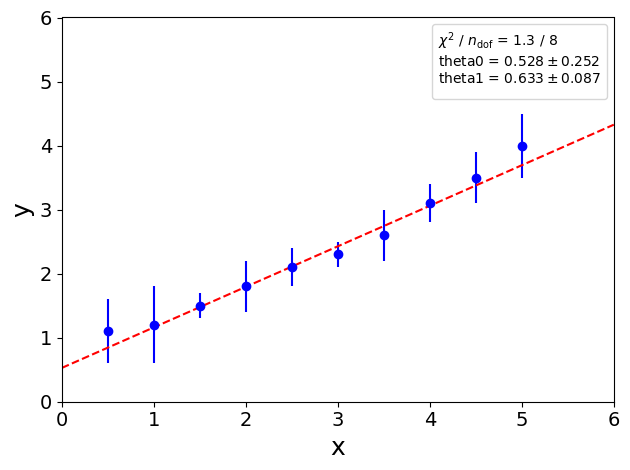

In [9]:
plt.xlabel("x", fontsize=18)
plt.ylabel("y", fontsize=18)
plt.errorbar(xd, yd, yerr=yd_err, fmt="bo")
plt.xlim(0., 6.)
plt.ylim(0., 6.)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(xf, yf, color="red", linestyle='dashed')

fit_info = [ f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(xd) - m.nfit}" ]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info))
plt.tight_layout()
# plt.savefig("basic_chi2_fit_plot1.pdf")

**Calculate the χ2 per degree of freedom and p-value**

In [10]:
from scipy import stats

chi2 = m.fval

n_data_points = xd.size
n_fit_parameters = 2
n_dof = n_data_points - n_fit_parameters
pvalue = 1 - stats.chi2.cdf(chi2, n_dof)

print(f"chi2/ndf = {chi2:.1f} / {n_dof}, p-value = {pvalue:.3f}")

chi2/ndf = 1.3 / 8, p-value = 0.996


**Error ellipse**

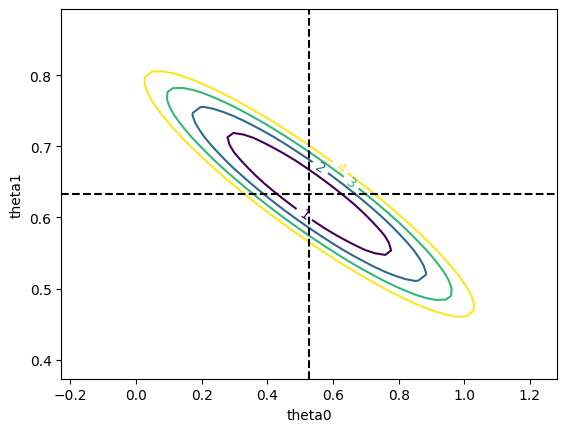

In [11]:
m.draw_contour('theta0','theta1', bound=3);

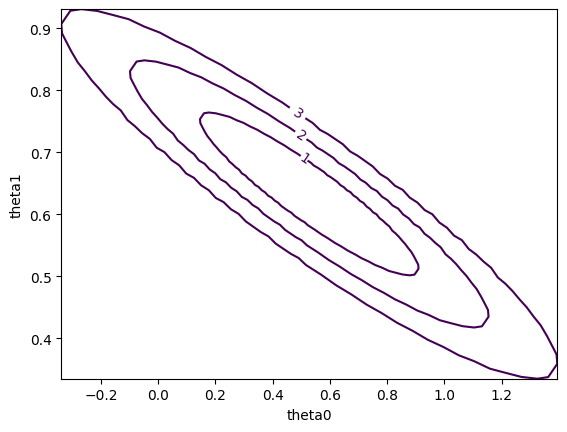

In [12]:
m.draw_mncontour('theta0','theta1',cl=1);
m.draw_mncontour('theta0','theta1',cl=2);
m.draw_mncontour('theta0','theta1',cl=3);

In [13]:
def get_error_ellipse(cov, center, nstd, **kwargs):
    """
    return error ellipse patch representing the covariance matrix
    cov: 2x2 covariance matrix
    centre: mean values (mu1, mu2)
    nstd: number of standard deviations
    """

    # eigenvalues and eigenvectors of the covariance matrix
    # (in ascending order of the eigenvalue)
    eigvals, eigvecs = np.linalg.eigh(cov)

    # x, y component of the eigenvector (eigvecs[:,1]) with the larger eigenvalue
    x, y = eigvecs[:,1][0], eigvecs[:,1][1]

    # angle of the ellipse
    theta = np.arctan2(y, x)

    # width = 2 times radius in x, height = 2 times radius in y
    height, width = 2 * nstd * np.sqrt(eigvals)

    return Ellipse(xy=center, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)

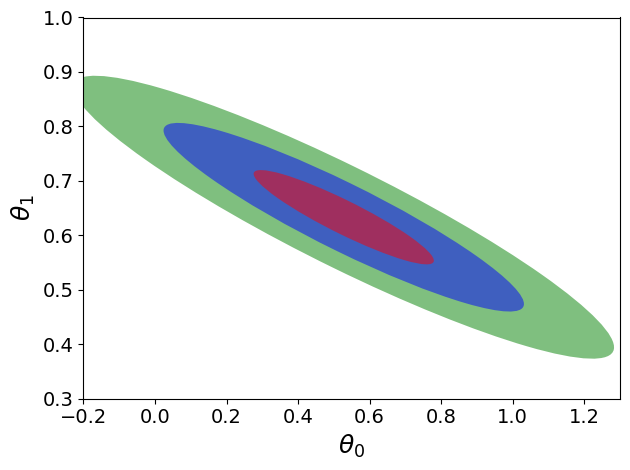

In [14]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots()
el_1sigma = get_error_ellipse(m.covariance, (theta0, theta1), 1, fc='red', alpha=0.5)
el_2sigma = get_error_ellipse(m.covariance, (theta0, theta1), 2, fc='blue', alpha=0.5)
el_3sigma = get_error_ellipse(m.covariance, (theta0, theta1), 3, fc='green', alpha=0.5)
ax.add_artist(el_3sigma)
ax.add_artist(el_2sigma)
ax.add_artist(el_1sigma)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlim(-0.2, 1.3)
ax.set_ylim(0.3, 1.)
plt.xlabel(r"$\theta_0$", fontsize=18)
plt.ylabel(r"$\theta_1$", fontsize=18)
plt.tight_layout()
#plt.savefig("basic_chi2_fit_plot2.pdf")

**Error band around fit function (propagation of fit parameter uncertainties)**


In [15]:
# error propagation of the uncertainties of the fit parameters (see lecture slides)
Var_yf = m.covariance[1][1] * xf**2 + 2. * m.covariance[1][0] * xf + m.covariance[0][0]
sigma_yf = np.sqrt(Var_yf)

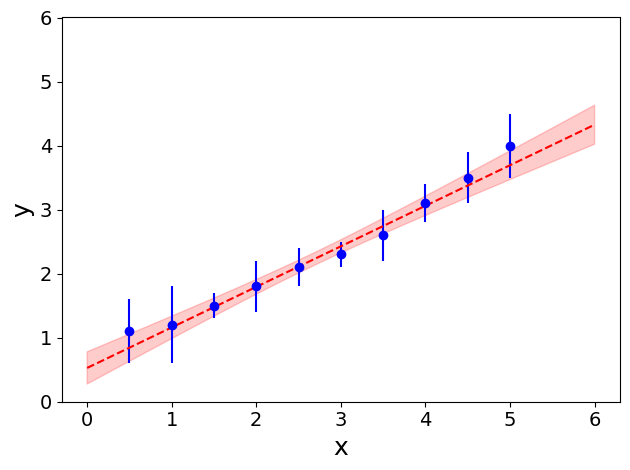

In [16]:
fig, ax = plt.subplots()
plt.xlabel("x", fontsize=18)
plt.ylabel("y", fontsize=18)
plt.errorbar(xd, yd, yerr=yd_err, fmt="bo")
ax.fill_between(xf, yf - sigma_yf, yf + sigma_yf, alpha=0.2, color='red',hatch='')
plt.ylim(0., 6.)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(xf, yf, color="red",linestyle='dashed')
plt.tight_layout()
# plt.savefig("basic_chi2_fit_plot3.pdf")